# Import

In [1]:
import kagglehub
import os
from pathlib import Path
import sys
import numpy as np 
import tqdm
import torch
parent_root = Path.cwd().parent
project_root = os.path.join(parent_root, "src")
sys.path.insert(0, str(project_root))
from pytorch_lightning import seed_everything
from accelerate import Accelerator
import matplotlib.pyplot as plt
import hydra
from utils import dice_macro

from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig, OmegaConf
from hydra import compose, initialize

from datamodule import DataModule_seg
from lightning_module import Modelelightning_seg


In [2]:
out_dir = Path("..") / "src"
data_dir = out_dir / "data"

# Def datamodule / model

In [3]:
@hydra.main(config_path="config", config_name="config_seg", version_base="1.3")
def main(cfg: DictConfig):

    seed_everything(cfg.get("seed", 42), workers=True)

    cfg_data = cfg.data
    cfg_model = cfg.model

    datamodule = DataModule_seg(cfg_data)
    model = Modelelightning_seg(cfg_model)
    return model, datamodule


GlobalHydra.instance().clear()
config_path = os.path.join(out_dir, "config")

with initialize(version_base=None, config_path=config_path, job_name="nb"):
    cfg = compose(config_name="config_seg")
    model, datamodule = main(cfg)
    

Seed set to 42


In [4]:
datamodule.setup(stage="test")
test_loader = datamodule.test_dataloader()

In [5]:

ckpt_path = out_dir / "checkpoints/best-v1.ckpt"
model = Modelelightning_seg.load_from_checkpoint(
    ckpt_path,
    weights_only = False
)


In [6]:
accelerator = Accelerator(mixed_precision="bf16")
model = accelerator.prepare(
    model
)

model.eval()

Modelelightning_seg(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b

# Test model

In [7]:
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

iou_list, dice_mean_list, dice_liver_list, dice_tumor_list = [], [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test eval"):
        # support (x,y) only
        x, y = batch
        x = x.to(device)
        y = y.to(device).long()          # [B,H,W]

        logits = model(x)                # [B,C,H,W]
        preds = torch.argmax(logits, dim=1)

        iou = model.iou(preds, y)
        dice_mean, dice_c = dice_macro(preds, y, num_classes=3)

        iou_list.append(iou.item())
        dice_mean_list.append(dice_mean.item())
        dice_liver_list.append(dice_c[1].item())
        dice_tumor_list.append(dice_c[2].item())

results = {
    "iou_macro": float(np.mean(iou_list)),
    "dice_macro": float(np.mean(dice_mean_list)),
    "dice_liver": float(np.mean(dice_liver_list)),
    "dice_tumor": float(np.mean(dice_tumor_list)),
    "iou_all": (iou_list),
    "dice_liver_all" : (dice_liver_list),
    "dice_tumor_all": (dice_tumor_list)
}
print(results)


Test eval: 100%|██████████| 26/26 [00:03<00:00,  6.58it/s]

{'iou_macro': 0.7452112986491277, 'dice_macro': 0.7823582291603088, 'dice_liver': 0.9545976267411158, 'dice_tumor': 0.3951429526675806, 'iou_all': [0.8173204660415649, 0.6484366655349731, 0.6663700342178345, 0.613852858543396, 0.908405601978302, 0.8969887495040894, 0.8471781015396118, 0.9329240322113037, 0.9053812026977539, 0.8307119607925415, 0.9256142377853394, 0.8958321809768677, 0.7363501787185669, 0.6371580362319946, 0.7335484623908997, 0.5583139061927795, 0.6455739736557007, 0.6481161117553711, 0.8721556067466736, 0.7072145938873291, 0.6399376392364502, 0.5536311864852905, 0.6292546391487122, 0.8436405658721924, 0.6452754735946655, 0.6363072991371155], 'dice_liver_all': [0.9616303443908691, 0.9727386236190796, 0.9725618958473206, 0.9151469469070435, 0.9802293181419373, 0.9785885810852051, 0.9691069722175598, 0.9792318940162659, 0.9773193001747131, 0.9630020260810852, 0.9766551852226257, 0.9735494256019592, 0.9627915620803833, 0.9565466642379761, 0.9720563888549805, 0.813417851924

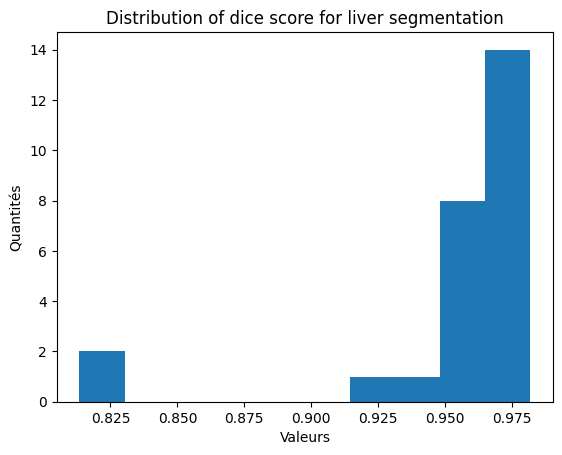

In [8]:
plt.title("Distribution of dice score for liver segmentation")
plt.xlabel("Valeurs")
plt.ylabel("Quantités")
plt.hist(results["dice_liver_all"], bins=10)
plt.show()

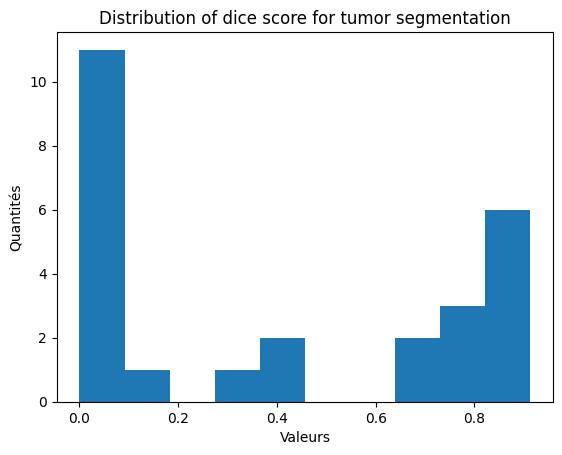

In [27]:
plt.title("Distribution of dice score for tumor segmentation")
plt.xlabel("Valeurs")
plt.ylabel("Quantités")
plt.hist(results["dice_tumor_all"], bins=10)
plt.show()

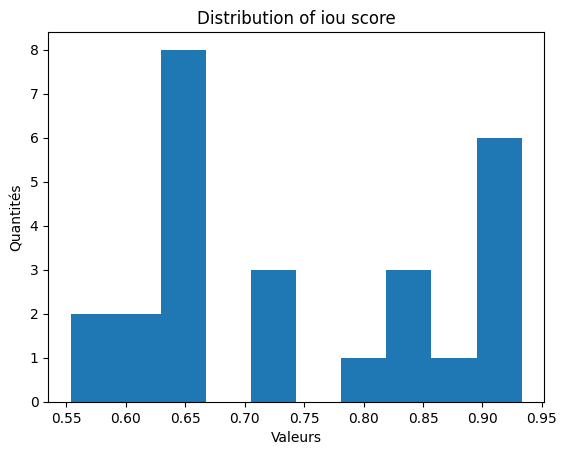

In [9]:
plt.title("Distribution of iou score")
plt.xlabel("Valeurs")
plt.ylabel("Quantités")
plt.hist(results["iou_all"], bins=10)
plt.show()

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def mask_to_rgba(mask_bool, color=(0,1,0), alpha=0.35):
    """mask_bool: [H,W] bool -> RGBA image"""
    h, w = mask_bool.shape
    rgba = np.zeros((h, w, 4), dtype=np.float32)
    rgba[..., 0] = color[0]
    rgba[..., 1] = color[1]
    rgba[..., 2] = color[2]
    rgba[..., 3] = alpha * mask_bool.astype(np.float32)
    return rgba

def show_case(img3, gt, pred, title="", save_path=None, alpha=0.35):
    img = img3.detach().cpu().permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)

    gt = gt.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()

    gt_liver = (gt == 1)
    gt_tumor = (gt == 2)
    pr_liver = (pred == 1)
    pr_tumor = (pred == 2)

    # overlays RGBA
    gt_liver_rgba = mask_to_rgba(gt_liver, color=(0,1,0), alpha=alpha)  # green
    gt_tumor_rgba = mask_to_rgba(gt_tumor, color=(1,0,0), alpha=alpha)  # red
    pr_liver_rgba = mask_to_rgba(pr_liver, color=(0,1,0), alpha=alpha)
    pr_tumor_rgba = mask_to_rgba(pr_tumor, color=(1,0,0), alpha=alpha)

    plt.figure(figsize=(14, 8))

    plt.subplot(2,2,1)
    plt.imshow(img)
    plt.title("CT")
    plt.axis("off")

    plt.subplot(2,2,2)
    plt.imshow(img)
    plt.imshow(gt_liver_rgba)
    plt.imshow(gt_tumor_rgba)
    # contours pour être sûr de voir
    plt.contour(gt_liver.astype(np.uint8), levels=[0.5], colors=["lime"], linewidths=1)
    plt.contour(gt_tumor.astype(np.uint8), levels=[0.5], colors=["red"], linewidths=1)
    plt.title("GT (liver=green, tumor=red)")
    plt.axis("off")

    plt.subplot(2,2,3)
    plt.imshow(img)
    plt.imshow(pr_liver_rgba)
    plt.imshow(pr_tumor_rgba)
    plt.contour(pr_liver.astype(np.uint8), levels=[0.5], colors=["lime"], linewidths=1)
    plt.contour(pr_tumor.astype(np.uint8), levels=[0.5], colors=["red"], linewidths=1)
    plt.title("Pred (liver=green, tumor=red)")
    plt.axis("off")

    # erreurs tumeur: FP en jaune, FN en cyan
    fp = pr_tumor & (~gt_tumor)
    fn = gt_tumor & (~pr_tumor)
    fp_rgba = mask_to_rgba(fp, color=(1,1,0), alpha=alpha)   # yellow
    fn_rgba = mask_to_rgba(fn, color=(0,1,1), alpha=alpha)   # cyan

    plt.subplot(2,2,4)
    plt.imshow(img)
    plt.imshow(fp_rgba)
    plt.imshow(fn_rgba)
    plt.contour(fp.astype(np.uint8), levels=[0.5], colors=["yellow"], linewidths=1)
    plt.contour(fn.astype(np.uint8), levels=[0.5], colors=["cyan"], linewidths=1)
    plt.title("Tumor errors (FP=yellow, FN=cyan)")
    plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150)
        plt.close()
    else:
        plt.show()


In [35]:
@torch.no_grad()
def collect_best_worst_examples(model, test_loader, device, k=2, num_classes=3):
    model.eval()
    model.to(device)

    # store list of (score, img, gt, pred)
    liver_cases = []
    tumor_cases = []

    for x, y in tqdm.tqdm(test_loader, desc="Collect examples"):
        x = x.to(device)
        y = y.to(device).long()

        logits = model(x)
        pred = torch.argmax(logits, dim=1)  # [B,H,W]

        B = x.shape[0]
        for i in range(B):
            _,dices = dice_macro(pred[i], y[i], num_classes=num_classes)  # [C]
            dice_liver = dices[1].item()
            dice_tumor = dices[2].item()

            # move to cpu for saving/display
            xi = x[i].detach().cpu()
            yi = y[i].detach().cpu()
            pi = pred[i].detach().cpu()

            liver_cases.append((dice_liver, xi, yi, pi))
            tumor_cases.append((dice_tumor, xi, yi, pi))

    # sort
    liver_cases.sort(key=lambda t: t[0])
    tumor_cases.sort(key=lambda t: t[0])

    # worst = first k, best = last k
    liver_worst = liver_cases[:k]
    liver_best  = liver_cases[-k:]
    tumor_worst = tumor_cases[:k]
    tumor_best  = tumor_cases[-k:]

    return liver_best, liver_worst, tumor_best, tumor_worst


In [ ]:
def show_and_save_examples(liver_best, liver_worst, tumor_best, tumor_worst, out_dir="reports/examples"):
    out_dir = Path(out_dir)

    # Liver
    for j, (score, img, gt, pred) in enumerate(reversed(liver_best), 1):
        title = f"LIVER BEST #{j} | Dice_liver={score:.3f}"
        show_case(img, gt, pred, title=title)

    for j, (score, img, gt, pred) in enumerate(liver_worst, 1):
        title = f"LIVER WORST #{j} | Dice_liver={score:.3f}"
        show_case(img, gt, pred, title=title)

    # Tumor
    for j, (score, img, gt, pred) in enumerate(reversed(tumor_best), 1):
        title = f"TUMOR BEST #{j} | Dice_tumor={score:.3f}"
        show_case(img, gt, pred, title=title)

    for j, (score, img, gt, pred) in enumerate(tumor_worst, 1):
        title = f"TUMOR WORST #{j} | Dice_tumor={score:.3f}"
        show_case(img, gt, pred, title=title)



Collect examples: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s]


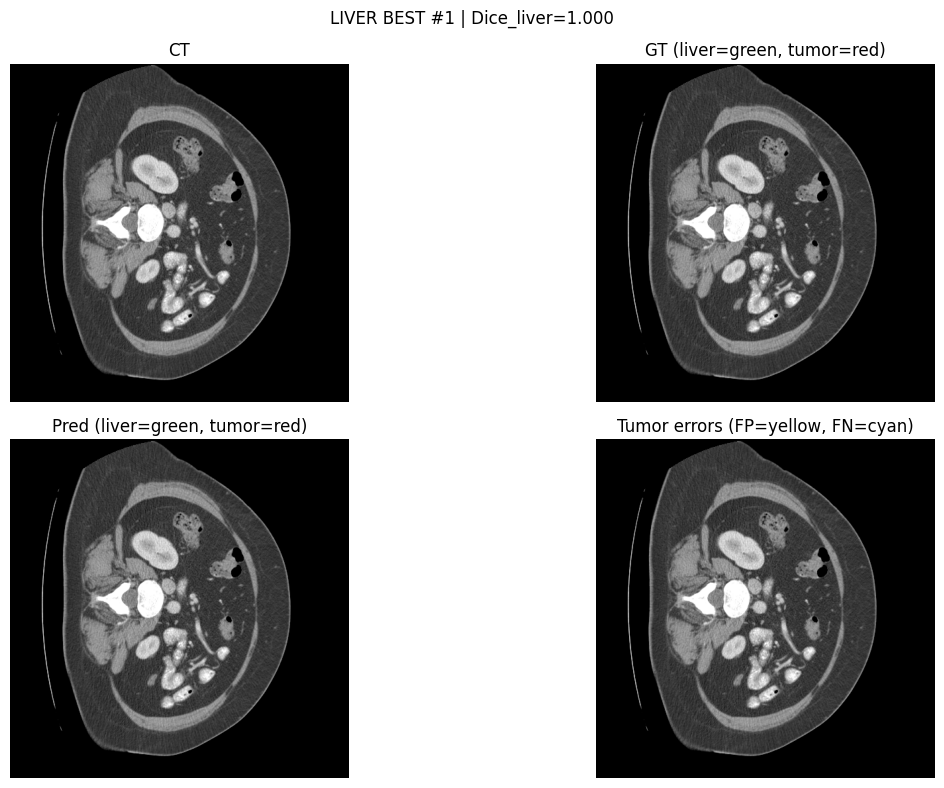

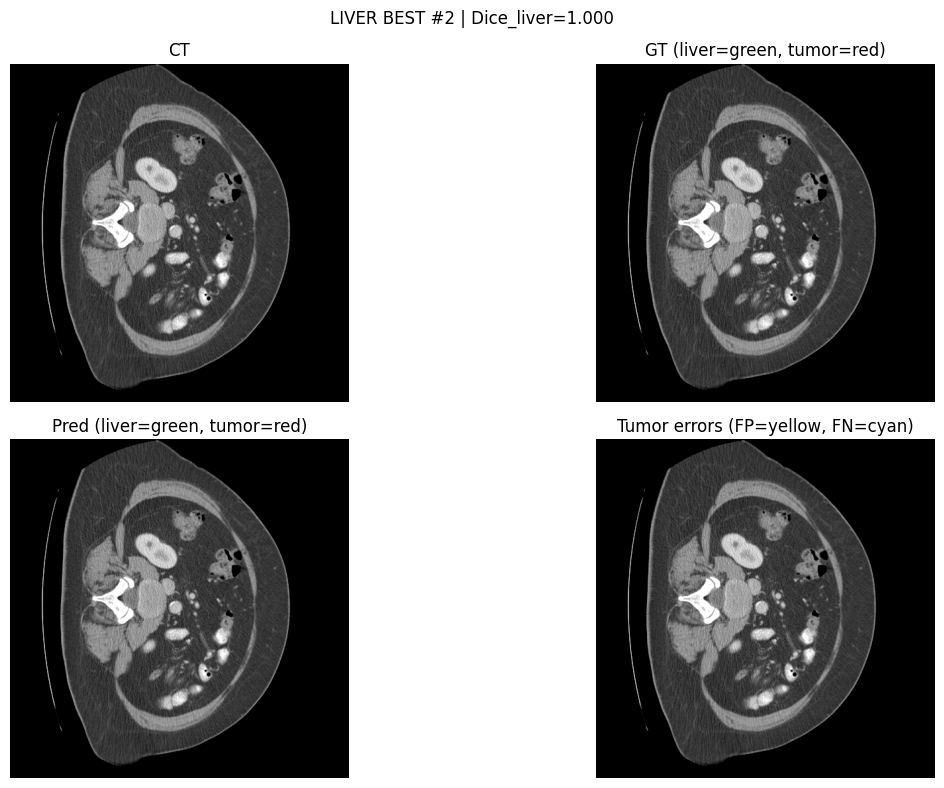

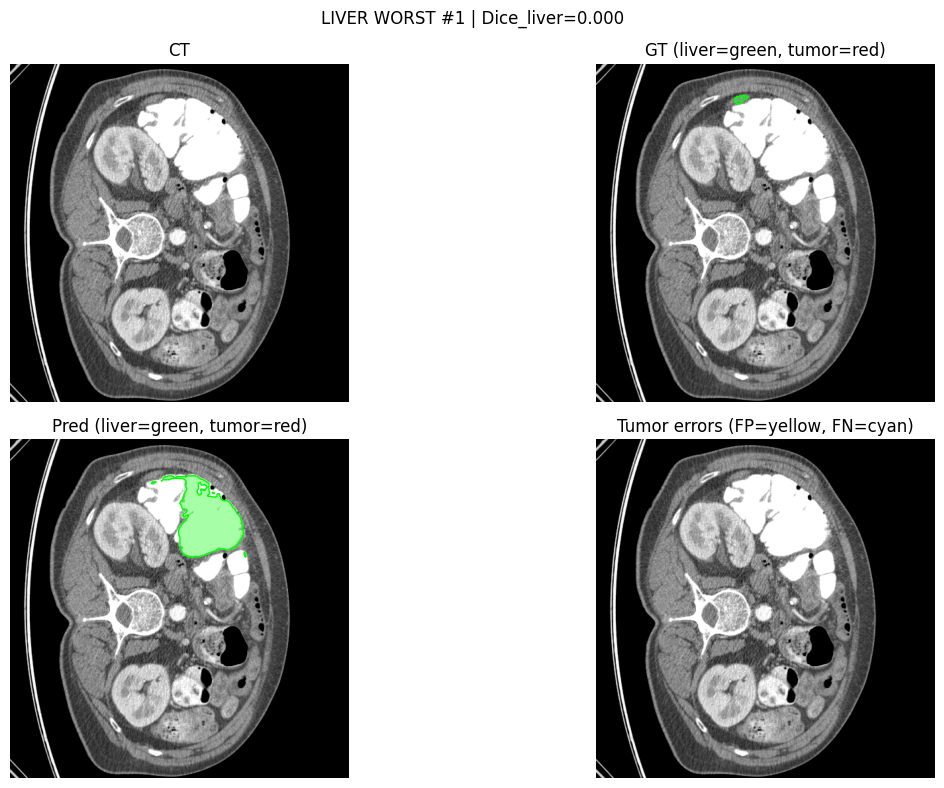

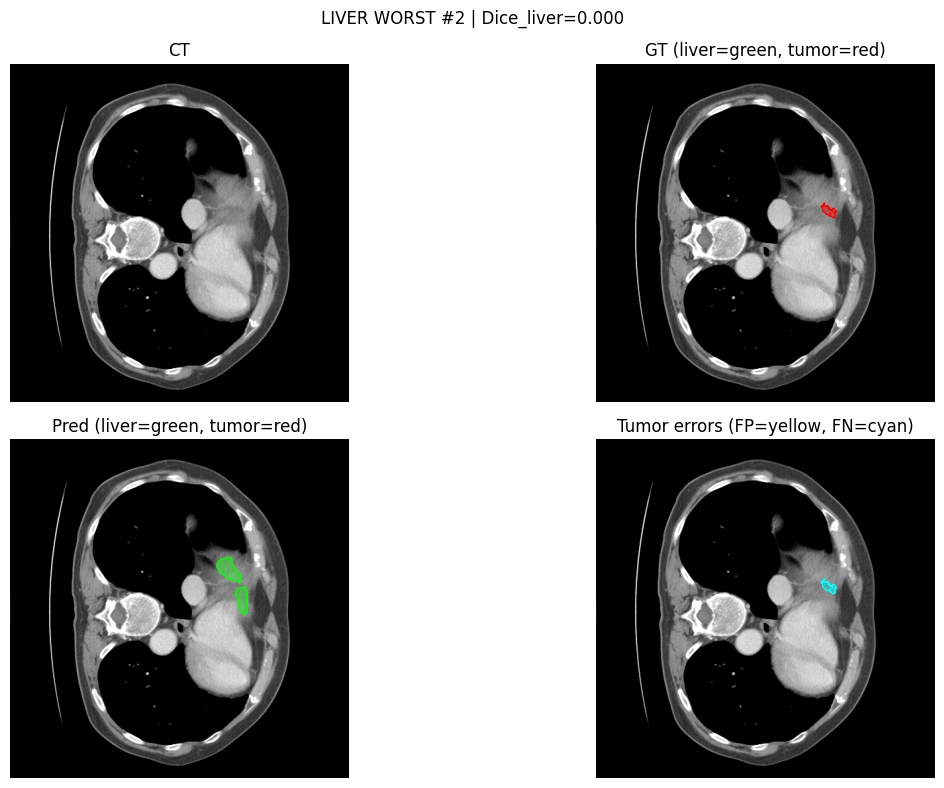

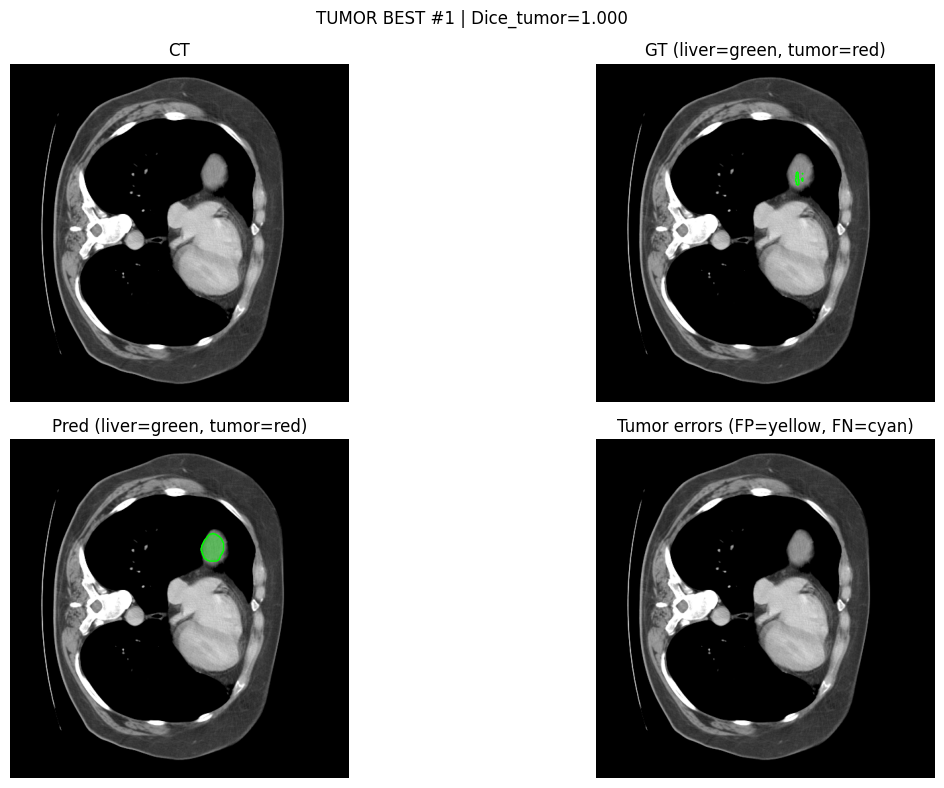

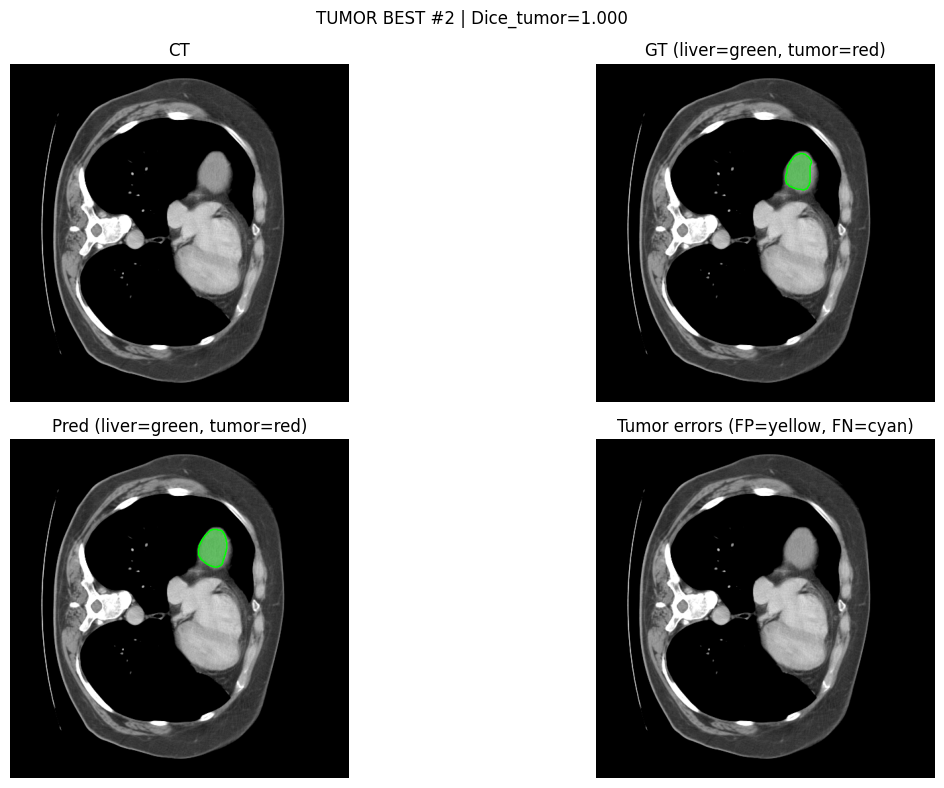

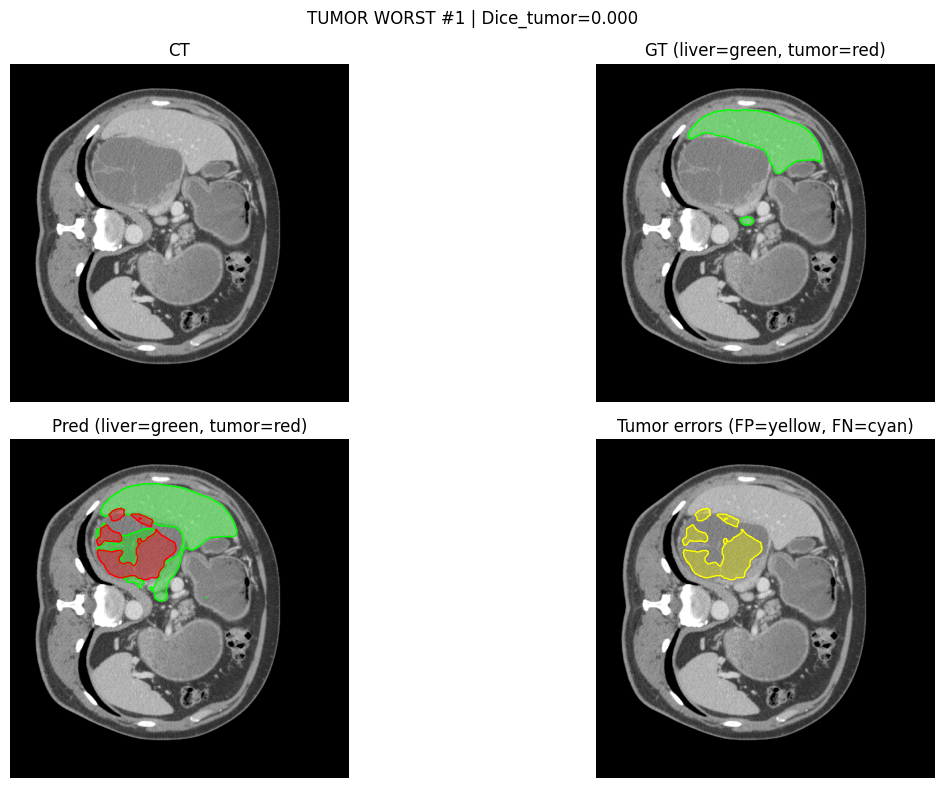

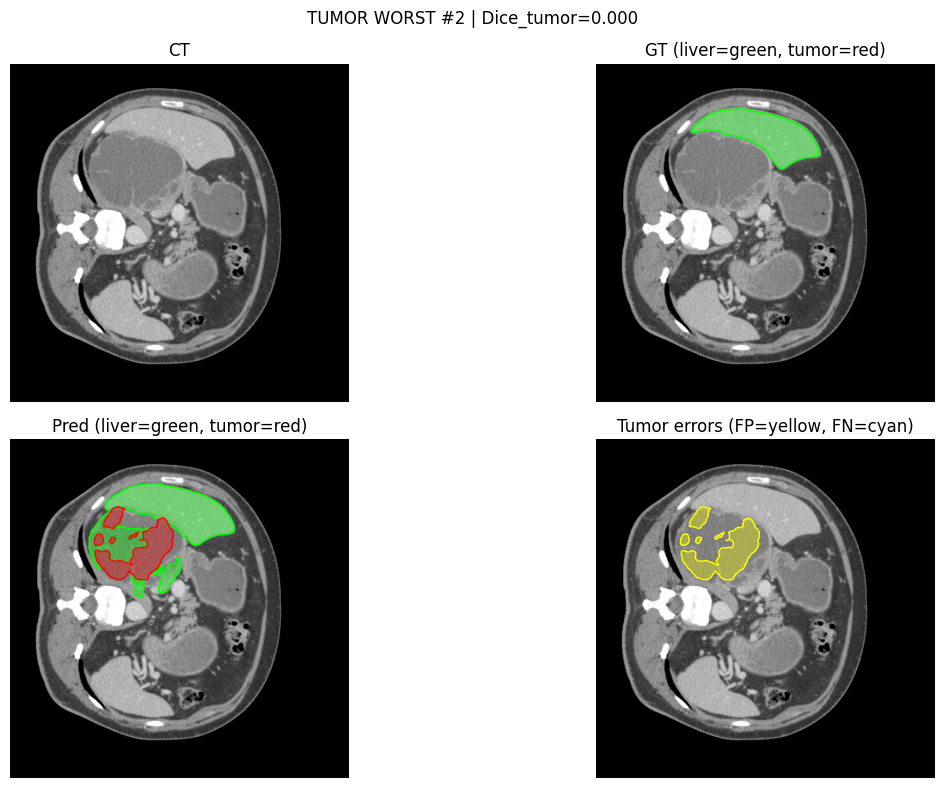

Saved examples to: reports/examples


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

liver_best, liver_worst, tumor_best, tumor_worst = collect_best_worst_examples(
    model=model,
    test_loader=test_loader,
    device=device,
    k=2,
    num_classes=3,
)

show_and_save_examples(
    liver_best, liver_worst, tumor_best, tumor_worst,
    out_dir="reports/examples"
)
